<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[09:13:57] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


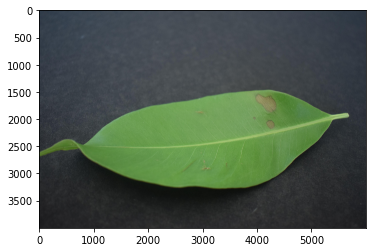

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

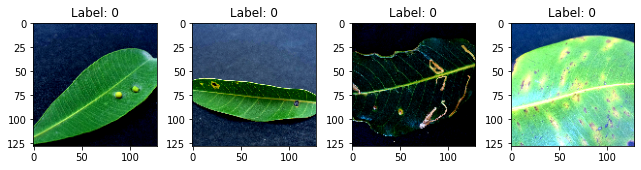

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[09:14:03] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[09:14:05] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:106: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2607951707289469 samples/sec                   batch loss = 0.31023144721984863 | accuracy = 0.55


Epoch[1] Batch[10] Speed: 1.2273780573497213 samples/sec                   batch loss = 1.8082752227783203 | accuracy = 0.525


Epoch[1] Batch[15] Speed: 1.2677805692553907 samples/sec                   batch loss = 0.4744917154312134 | accuracy = 0.55


Epoch[1] Batch[20] Speed: 1.277303057699445 samples/sec                   batch loss = 0.7358659505844116 | accuracy = 0.6


Epoch[1] Batch[25] Speed: 1.2641359007336446 samples/sec                   batch loss = 1.3658167123794556 | accuracy = 0.6


Epoch[1] Batch[30] Speed: 1.2731651105496349 samples/sec                   batch loss = 0.455973356962204 | accuracy = 0.6083333333333333


Epoch[1] Batch[35] Speed: 1.2417272109132036 samples/sec                   batch loss = 0.20766915380954742 | accuracy = 0.6285714285714286


Epoch[1] Batch[40] Speed: 1.272291913713374 samples/sec                   batch loss = 0.549744188785553 | accuracy = 0.6


Epoch[1] Batch[45] Speed: 1.2661716306491249 samples/sec                   batch loss = 0.7729614973068237 | accuracy = 0.5888888888888889


Epoch[1] Batch[50] Speed: 1.26272757234812 samples/sec                   batch loss = 0.6811692714691162 | accuracy = 0.605


Epoch[1] Batch[55] Speed: 1.2692827763260817 samples/sec                   batch loss = 0.410001665353775 | accuracy = 0.6181818181818182


Epoch[1] Batch[60] Speed: 1.2646083296040795 samples/sec                   batch loss = 1.1452348232269287 | accuracy = 0.6166666666666667


Epoch[1] Batch[65] Speed: 1.269986954358118 samples/sec                   batch loss = 1.0516877174377441 | accuracy = 0.6269230769230769


Epoch[1] Batch[70] Speed: 1.2575942098490465 samples/sec                   batch loss = 0.598588764667511 | accuracy = 0.6321428571428571


Epoch[1] Batch[75] Speed: 1.272491666185674 samples/sec                   batch loss = 0.6250585913658142 | accuracy = 0.62


Epoch[1] Batch[80] Speed: 1.2614007104262897 samples/sec                   batch loss = 0.46993452310562134 | accuracy = 0.63125


Epoch[1] Batch[85] Speed: 1.264825891346997 samples/sec                   batch loss = 0.45876964926719666 | accuracy = 0.6352941176470588


Epoch[1] Batch[90] Speed: 1.267628743468702 samples/sec                   batch loss = 0.3308483064174652 | accuracy = 0.6444444444444445


Epoch[1] Batch[95] Speed: 1.2658080428363785 samples/sec                   batch loss = 1.1878654956817627 | accuracy = 0.6447368421052632


Epoch[1] Batch[100] Speed: 1.259485885336536 samples/sec                   batch loss = 0.5207838416099548 | accuracy = 0.6375


Epoch[1] Batch[105] Speed: 1.2719701257283484 samples/sec                   batch loss = 0.8077758550643921 | accuracy = 0.6357142857142857


Epoch[1] Batch[110] Speed: 1.269889289363147 samples/sec                   batch loss = 0.4527340531349182 | accuracy = 0.634090909090909


Epoch[1] Batch[115] Speed: 1.2732755523464565 samples/sec                   batch loss = 0.3277088403701782 | accuracy = 0.6413043478260869


Epoch[1] Batch[120] Speed: 1.2684339786232652 samples/sec                   batch loss = 0.41304337978363037 | accuracy = 0.6458333333333334


Epoch[1] Batch[125] Speed: 1.25520117712219 samples/sec                   batch loss = 0.4695851802825928 | accuracy = 0.648


Epoch[1] Batch[130] Speed: 1.2649381336578385 samples/sec                   batch loss = 0.5734739899635315 | accuracy = 0.6480769230769231


Epoch[1] Batch[135] Speed: 1.2590883288209767 samples/sec                   batch loss = 0.6187496781349182 | accuracy = 0.6481481481481481


Epoch[1] Batch[140] Speed: 1.2615200289761637 samples/sec                   batch loss = 0.7330866456031799 | accuracy = 0.65


Epoch[1] Batch[145] Speed: 1.2688094399356507 samples/sec                   batch loss = 0.537406325340271 | accuracy = 0.6482758620689655


Epoch[1] Batch[150] Speed: 1.2567844097515386 samples/sec                   batch loss = 0.5068525075912476 | accuracy = 0.65


Epoch[1] Batch[155] Speed: 1.2664125772164312 samples/sec                   batch loss = 0.4641903340816498 | accuracy = 0.65


Epoch[1] Batch[160] Speed: 1.2625819902000457 samples/sec                   batch loss = 0.6181177496910095 | accuracy = 0.6546875


Epoch[1] Batch[165] Speed: 1.264988205684419 samples/sec                   batch loss = 0.4219696521759033 | accuracy = 0.656060606060606


Epoch[1] Batch[170] Speed: 1.2683706881848675 samples/sec                   batch loss = 0.4102970361709595 | accuracy = 0.6573529411764706


Epoch[1] Batch[175] Speed: 1.2650642273668997 samples/sec                   batch loss = 1.3270646333694458 | accuracy = 0.6557142857142857


Epoch[1] Batch[180] Speed: 1.2715257164792597 samples/sec                   batch loss = 0.37150970101356506 | accuracy = 0.6569444444444444


Epoch[1] Batch[185] Speed: 1.2641481881780572 samples/sec                   batch loss = 0.16765011847019196 | accuracy = 0.6567567567567567


Epoch[1] Batch[190] Speed: 1.2728590077001782 samples/sec                   batch loss = 1.152722954750061 | accuracy = 0.6539473684210526


Epoch[1] Batch[195] Speed: 1.2693425084145724 samples/sec                   batch loss = 0.4892689883708954 | accuracy = 0.6538461538461539


Epoch[1] Batch[200] Speed: 1.266204790006824 samples/sec                   batch loss = 0.44298887252807617 | accuracy = 0.65625


Epoch[1] Batch[205] Speed: 1.268060272939714 samples/sec                   batch loss = 0.40224453806877136 | accuracy = 0.6609756097560976


Epoch[1] Batch[210] Speed: 1.2726884885264556 samples/sec                   batch loss = 0.8805773854255676 | accuracy = 0.6583333333333333


Epoch[1] Batch[215] Speed: 1.2718079430232525 samples/sec                   batch loss = 0.7093398571014404 | accuracy = 0.6604651162790698


Epoch[1] Batch[220] Speed: 1.2680515512967752 samples/sec                   batch loss = 0.5418168306350708 | accuracy = 0.6602272727272728


Epoch[1] Batch[225] Speed: 1.2718798691308033 samples/sec                   batch loss = 0.7415716052055359 | accuracy = 0.6622222222222223


Epoch[1] Batch[230] Speed: 1.2603624165772822 samples/sec                   batch loss = 0.7256900072097778 | accuracy = 0.6630434782608695


Epoch[1] Batch[235] Speed: 1.2718487258630826 samples/sec                   batch loss = 0.2505890429019928 | accuracy = 0.6659574468085107


Epoch[1] Batch[240] Speed: 1.2670900315654443 samples/sec                   batch loss = 0.300225168466568 | accuracy = 0.66875


Epoch[1] Batch[245] Speed: 1.2710555208571033 samples/sec                   batch loss = 1.3118486404418945 | accuracy = 0.6714285714285714


Epoch[1] Batch[250] Speed: 1.2785934418610996 samples/sec                   batch loss = 0.34594660997390747 | accuracy = 0.674


Epoch[1] Batch[255] Speed: 1.2714361974142063 samples/sec                   batch loss = 0.43034011125564575 | accuracy = 0.6745098039215687


Epoch[1] Batch[260] Speed: 1.2757143969477536 samples/sec                   batch loss = 0.8593541383743286 | accuracy = 0.6730769230769231


Epoch[1] Batch[265] Speed: 1.267874844068214 samples/sec                   batch loss = 0.394877552986145 | accuracy = 0.6745283018867925


Epoch[1] Batch[270] Speed: 1.266341172541198 samples/sec                   batch loss = 0.5463017821311951 | accuracy = 0.6703703703703704


Epoch[1] Batch[275] Speed: 1.2695052156341524 samples/sec                   batch loss = 0.7261292338371277 | accuracy = 0.6718181818181819


Epoch[1] Batch[280] Speed: 1.271794831365603 samples/sec                   batch loss = 0.660843014717102 | accuracy = 0.6732142857142858


Epoch[1] Batch[285] Speed: 1.267879826460569 samples/sec                   batch loss = 0.8793339729309082 | accuracy = 0.6745614035087719


Epoch[1] Batch[290] Speed: 1.268315362172817 samples/sec                   batch loss = 0.7314462065696716 | accuracy = 0.6724137931034483


Epoch[1] Batch[295] Speed: 1.2669860182488344 samples/sec                   batch loss = 0.6874487996101379 | accuracy = 0.673728813559322


Epoch[1] Batch[300] Speed: 1.279447796921754 samples/sec                   batch loss = 0.4731071889400482 | accuracy = 0.6741666666666667


Epoch[1] Batch[305] Speed: 1.273929512824099 samples/sec                   batch loss = 0.4313499927520752 | accuracy = 0.6745901639344263


Epoch[1] Batch[310] Speed: 1.265371745774952 samples/sec                   batch loss = 0.21486759185791016 | accuracy = 0.6758064516129032


Epoch[1] Batch[315] Speed: 1.2719216208577602 samples/sec                   batch loss = 0.39465606212615967 | accuracy = 0.6785714285714286


Epoch[1] Batch[320] Speed: 1.274708392460467 samples/sec                   batch loss = 0.34283941984176636 | accuracy = 0.6796875


Epoch[1] Batch[325] Speed: 1.2779360482631164 samples/sec                   batch loss = 0.39938458800315857 | accuracy = 0.68


Epoch[1] Batch[330] Speed: 1.2704971520011341 samples/sec                   batch loss = 0.7524834275245667 | accuracy = 0.6803030303030303


Epoch[1] Batch[335] Speed: 1.2769590969624718 samples/sec                   batch loss = 0.5060378313064575 | accuracy = 0.6805970149253732


Epoch[1] Batch[340] Speed: 1.274916655021053 samples/sec                   batch loss = 0.38367438316345215 | accuracy = 0.6816176470588236


Epoch[1] Batch[345] Speed: 1.2651904416269972 samples/sec                   batch loss = 0.6716025471687317 | accuracy = 0.6826086956521739


Epoch[1] Batch[350] Speed: 1.2644473515983594 samples/sec                   batch loss = 0.29985740780830383 | accuracy = 0.685


Epoch[1] Batch[355] Speed: 1.2778548705507866 samples/sec                   batch loss = 0.2873469889163971 | accuracy = 0.6866197183098591


Epoch[1] Batch[360] Speed: 1.276017216465544 samples/sec                   batch loss = 0.3240823447704315 | accuracy = 0.6854166666666667


Epoch[1] Batch[365] Speed: 1.266511907149725 samples/sec                   batch loss = 0.6475433707237244 | accuracy = 0.684931506849315


Epoch[1] Batch[370] Speed: 1.2664188864504058 samples/sec                   batch loss = 0.6460328102111816 | accuracy = 0.6844594594594594


Epoch[1] Batch[375] Speed: 1.2684477882855816 samples/sec                   batch loss = 0.8512792587280273 | accuracy = 0.6846666666666666


Epoch[1] Batch[380] Speed: 1.263882204109263 samples/sec                   batch loss = 0.5110949277877808 | accuracy = 0.6888157894736842


Epoch[1] Batch[385] Speed: 1.2647382665506552 samples/sec                   batch loss = 1.1790931224822998 | accuracy = 0.6883116883116883


Epoch[1] Batch[390] Speed: 1.2701713668282177 samples/sec                   batch loss = 0.5718778967857361 | accuracy = 0.6884615384615385


Epoch[1] Batch[395] Speed: 1.266880969694773 samples/sec                   batch loss = 0.8530961275100708 | accuracy = 0.6892405063291139


Epoch[1] Batch[400] Speed: 1.274402902413913 samples/sec                   batch loss = 0.38243138790130615 | accuracy = 0.69


Epoch[1] Batch[405] Speed: 1.2771225961770853 samples/sec                   batch loss = 0.6198453307151794 | accuracy = 0.691358024691358


Epoch[1] Batch[410] Speed: 1.2667642695076695 samples/sec                   batch loss = 0.5860456228256226 | accuracy = 0.6914634146341463


Epoch[1] Batch[415] Speed: 1.2798986408394477 samples/sec                   batch loss = 0.24343593418598175 | accuracy = 0.6933734939759036


Epoch[1] Batch[420] Speed: 1.268524418194687 samples/sec                   batch loss = 0.48689699172973633 | accuracy = 0.694047619047619


Epoch[1] Batch[425] Speed: 1.2666298996153804 samples/sec                   batch loss = 0.3238967955112457 | accuracy = 0.6952941176470588


Epoch[1] Batch[430] Speed: 1.2805279520456585 samples/sec                   batch loss = 0.467399001121521 | accuracy = 0.6941860465116279


Epoch[1] Batch[435] Speed: 1.2708180987860689 samples/sec                   batch loss = 0.8074467778205872 | accuracy = 0.6919540229885057


Epoch[1] Batch[440] Speed: 1.2718924040033808 samples/sec                   batch loss = 0.318480521440506 | accuracy = 0.6931818181818182


Epoch[1] Batch[445] Speed: 1.2726340401594045 samples/sec                   batch loss = 0.8294177651405334 | accuracy = 0.6915730337078652


Epoch[1] Batch[450] Speed: 1.2781500408611164 samples/sec                   batch loss = 1.6559717655181885 | accuracy = 0.6905555555555556


Epoch[1] Batch[455] Speed: 1.2729548120137708 samples/sec                   batch loss = 0.11022870987653732 | accuracy = 0.6884615384615385


Epoch[1] Batch[460] Speed: 1.2670485007415124 samples/sec                   batch loss = 0.2881584167480469 | accuracy = 0.6902173913043478


Epoch[1] Batch[465] Speed: 1.2695784186706518 samples/sec                   batch loss = 0.5715516209602356 | accuracy = 0.6913978494623656


Epoch[1] Batch[470] Speed: 1.270195792516412 samples/sec                   batch loss = 0.7254703640937805 | accuracy = 0.6930851063829787


Epoch[1] Batch[475] Speed: 1.2725782450706717 samples/sec                   batch loss = 0.18770593404769897 | accuracy = 0.6942105263157895


Epoch[1] Batch[480] Speed: 1.2754116241664166 samples/sec                   batch loss = 0.6200817823410034 | accuracy = 0.6947916666666667


Epoch[1] Batch[485] Speed: 1.2705714317088954 samples/sec                   batch loss = 0.7926236987113953 | accuracy = 0.6938144329896907


Epoch[1] Batch[490] Speed: 1.2694368235750686 samples/sec                   batch loss = 0.7217821478843689 | accuracy = 0.6938775510204082


Epoch[1] Batch[495] Speed: 1.2691231982249298 samples/sec                   batch loss = 0.5607223510742188 | accuracy = 0.6934343434343434


Epoch[1] Batch[500] Speed: 1.2684318688402234 samples/sec                   batch loss = 0.8127180337905884 | accuracy = 0.6935


Epoch[1] Batch[505] Speed: 1.2732797075736817 samples/sec                   batch loss = 0.3820851743221283 | accuracy = 0.692079207920792


Epoch[1] Batch[510] Speed: 1.2752558326981966 samples/sec                   batch loss = 0.4163013994693756 | accuracy = 0.692156862745098


Epoch[1] Batch[515] Speed: 1.269991953364334 samples/sec                   batch loss = 0.5851705074310303 | accuracy = 0.6922330097087379


Epoch[1] Batch[520] Speed: 1.2747686363084112 samples/sec                   batch loss = 0.4873879849910736 | accuracy = 0.6908653846153846


Epoch[1] Batch[525] Speed: 1.2649395642321586 samples/sec                   batch loss = 0.8187509179115295 | accuracy = 0.6904761904761905


Epoch[1] Batch[530] Speed: 1.2689694190400447 samples/sec                   batch loss = 0.4454713463783264 | accuracy = 0.6919811320754717


Epoch[1] Batch[535] Speed: 1.2630123718211768 samples/sec                   batch loss = 0.6144458055496216 | accuracy = 0.6901869158878504


Epoch[1] Batch[540] Speed: 1.2642091526750447 samples/sec                   batch loss = 0.32434582710266113 | accuracy = 0.6916666666666667


Epoch[1] Batch[545] Speed: 1.267757385931074 samples/sec                   batch loss = 1.2214699983596802 | accuracy = 0.6931192660550459


Epoch[1] Batch[550] Speed: 1.2694946489639378 samples/sec                   batch loss = 0.2949206233024597 | accuracy = 0.6940909090909091


Epoch[1] Batch[555] Speed: 1.269617521389189 samples/sec                   batch loss = 0.30384525656700134 | accuracy = 0.6918918918918919


Epoch[1] Batch[560] Speed: 1.2673176381951037 samples/sec                   batch loss = 0.8860830068588257 | accuracy = 0.6928571428571428


Epoch[1] Batch[565] Speed: 1.2769500580964077 samples/sec                   batch loss = 0.19238047301769257 | accuracy = 0.6933628318584071


Epoch[1] Batch[570] Speed: 1.2733722892042691 samples/sec                   batch loss = 0.5452552437782288 | accuracy = 0.6929824561403509


Epoch[1] Batch[575] Speed: 1.2675756848613353 samples/sec                   batch loss = 0.7871837615966797 | accuracy = 0.6939130434782609


Epoch[1] Batch[580] Speed: 1.2711267840398779 samples/sec                   batch loss = 0.7359643578529358 | accuracy = 0.694396551724138


Epoch[1] Batch[585] Speed: 1.2698441147717823 samples/sec                   batch loss = 0.5746147036552429 | accuracy = 0.6957264957264957


Epoch[1] Batch[590] Speed: 1.2717011294473815 samples/sec                   batch loss = 1.3918001651763916 | accuracy = 0.6944915254237288


Epoch[1] Batch[595] Speed: 1.2713668263994706 samples/sec                   batch loss = 0.49143725633621216 | accuracy = 0.6953781512605042


Epoch[1] Batch[600] Speed: 1.2785194878550215 samples/sec                   batch loss = 0.4625999927520752 | accuracy = 0.6966666666666667


Epoch[1] Batch[605] Speed: 1.270831190311963 samples/sec                   batch loss = 0.4445880353450775 | accuracy = 0.6983471074380165


Epoch[1] Batch[610] Speed: 1.2681998355450892 samples/sec                   batch loss = 0.9553033709526062 | accuracy = 0.6983606557377049


Epoch[1] Batch[615] Speed: 1.2756296215982443 samples/sec                   batch loss = 0.35163581371307373 | accuracy = 0.7004065040650407


Epoch[1] Batch[620] Speed: 1.272534519813457 samples/sec                   batch loss = 0.44926130771636963 | accuracy = 0.7016129032258065


Epoch[1] Batch[625] Speed: 1.267785934112403 samples/sec                   batch loss = 0.2739354074001312 | accuracy = 0.7024


Epoch[1] Batch[630] Speed: 1.2641335194735992 samples/sec                   batch loss = 0.537559986114502 | accuracy = 0.7011904761904761


Epoch[1] Batch[635] Speed: 1.270087038109918 samples/sec                   batch loss = 0.4348798096179962 | accuracy = 0.7015748031496063


Epoch[1] Batch[640] Speed: 1.2680089032321453 samples/sec                   batch loss = 1.6795463562011719 | accuracy = 0.701953125


Epoch[1] Batch[645] Speed: 1.2623332858563083 samples/sec                   batch loss = 0.22108358144760132 | accuracy = 0.7023255813953488


Epoch[1] Batch[650] Speed: 1.2624771956375755 samples/sec                   batch loss = 0.5531960725784302 | accuracy = 0.7026923076923077


Epoch[1] Batch[655] Speed: 1.267286047864076 samples/sec                   batch loss = 1.892160177230835 | accuracy = 0.7019083969465649


Epoch[1] Batch[660] Speed: 1.2654854213460813 samples/sec                   batch loss = 0.5014023780822754 | accuracy = 0.7026515151515151


Epoch[1] Batch[665] Speed: 1.2676125572494197 samples/sec                   batch loss = 0.31479331851005554 | accuracy = 0.7030075187969925


Epoch[1] Batch[670] Speed: 1.2677763540424483 samples/sec                   batch loss = 0.36149320006370544 | accuracy = 0.7033582089552238


Epoch[1] Batch[675] Speed: 1.2664020619661716 samples/sec                   batch loss = 0.4932447373867035 | accuracy = 0.7025925925925925


Epoch[1] Batch[680] Speed: 1.2714068101573919 samples/sec                   batch loss = 0.38374564051628113 | accuracy = 0.7018382352941176


Epoch[1] Batch[685] Speed: 1.26518815180162 samples/sec                   batch loss = 0.29842936992645264 | accuracy = 0.7014598540145985


Epoch[1] Batch[690] Speed: 1.2591088337989482 samples/sec                   batch loss = 0.7097763419151306 | accuracy = 0.702536231884058


Epoch[1] Batch[695] Speed: 1.267435780844689 samples/sec                   batch loss = 0.2488514482975006 | accuracy = 0.7043165467625899


Epoch[1] Batch[700] Speed: 1.2699687852246784 samples/sec                   batch loss = 0.3155204951763153 | accuracy = 0.7053571428571429


Epoch[1] Batch[705] Speed: 1.2723767284784384 samples/sec                   batch loss = 1.568089246749878 | accuracy = 0.7049645390070922


Epoch[1] Batch[710] Speed: 1.272098107625833 samples/sec                   batch loss = 0.27042248845100403 | accuracy = 0.7049295774647887


Epoch[1] Batch[715] Speed: 1.2697281173005701 samples/sec                   batch loss = 0.29506662487983704 | accuracy = 0.7055944055944056


Epoch[1] Batch[720] Speed: 1.2747565289685965 samples/sec                   batch loss = 0.2888753414154053 | accuracy = 0.7069444444444445


Epoch[1] Batch[725] Speed: 1.2622474305654354 samples/sec                   batch loss = 0.764686107635498 | accuracy = 0.7055172413793104


Epoch[1] Batch[730] Speed: 1.2627544688077244 samples/sec                   batch loss = 0.3088758587837219 | accuracy = 0.7058219178082191


Epoch[1] Batch[735] Speed: 1.2702128141222648 samples/sec                   batch loss = 0.9351630210876465 | accuracy = 0.7054421768707483


Epoch[1] Batch[740] Speed: 1.2681497006617166 samples/sec                   batch loss = 0.7031735777854919 | accuracy = 0.7050675675675676


Epoch[1] Batch[745] Speed: 1.2664840855494193 samples/sec                   batch loss = 0.339944064617157 | accuracy = 0.7057046979865772


Epoch[1] Batch[750] Speed: 1.2690009013821926 samples/sec                   batch loss = 0.5926060676574707 | accuracy = 0.7056666666666667


Epoch[1] Batch[755] Speed: 1.2678529986562912 samples/sec                   batch loss = 0.4424649178981781 | accuracy = 0.7062913907284768


Epoch[1] Batch[760] Speed: 1.268498042650382 samples/sec                   batch loss = 0.17997263371944427 | accuracy = 0.70625


Epoch[1] Batch[765] Speed: 1.2583996740519032 samples/sec                   batch loss = 0.5715941190719604 | accuracy = 0.7065359477124183


Epoch[1] Batch[770] Speed: 1.269200773902173 samples/sec                   batch loss = 0.5242344737052917 | accuracy = 0.7074675324675325


Epoch[1] Batch[775] Speed: 1.2711061746765453 samples/sec                   batch loss = 0.42298534512519836 | accuracy = 0.7074193548387097


Epoch[1] Batch[780] Speed: 1.2665090388869962 samples/sec                   batch loss = 0.5272288918495178 | accuracy = 0.7076923076923077


Epoch[1] Batch[785] Speed: 1.2593324475509464 samples/sec                   batch loss = 0.4529152810573578 | accuracy = 0.706687898089172


[Epoch 1] training: accuracy=0.7062182741116751
[Epoch 1] time cost: 648.8924100399017
[Epoch 1] validation: validation accuracy=0.7688888888888888


Epoch[2] Batch[5] Speed: 1.2652045623999801 samples/sec                   batch loss = 0.6328070163726807 | accuracy = 0.55


Epoch[2] Batch[10] Speed: 1.2746818559803554 samples/sec                   batch loss = 0.3128849267959595 | accuracy = 0.65


Epoch[2] Batch[15] Speed: 1.2799624034480799 samples/sec                   batch loss = 0.3497779369354248 | accuracy = 0.7166666666666667


Epoch[2] Batch[20] Speed: 1.2738849208575869 samples/sec                   batch loss = 0.2613619863986969 | accuracy = 0.7625


Epoch[2] Batch[25] Speed: 1.2676299885796145 samples/sec                   batch loss = 0.10237544775009155 | accuracy = 0.78


Epoch[2] Batch[30] Speed: 1.272078141911808 samples/sec                   batch loss = 0.5271957516670227 | accuracy = 0.775


Epoch[2] Batch[35] Speed: 1.2683444149187497 samples/sec                   batch loss = 0.9852181673049927 | accuracy = 0.7785714285714286


Epoch[2] Batch[40] Speed: 1.2616144185398759 samples/sec                   batch loss = 0.16059546172618866 | accuracy = 0.7875


Epoch[2] Batch[45] Speed: 1.2663116380217383 samples/sec                   batch loss = 0.5041924118995667 | accuracy = 0.7833333333333333


Epoch[2] Batch[50] Speed: 1.2648182630258886 samples/sec                   batch loss = 1.1530239582061768 | accuracy = 0.77


Epoch[2] Batch[55] Speed: 1.2670560602971053 samples/sec                   batch loss = 0.5402793884277344 | accuracy = 0.759090909090909


Epoch[2] Batch[60] Speed: 1.2631273356299264 samples/sec                   batch loss = 0.48018670082092285 | accuracy = 0.7583333333333333


Epoch[2] Batch[65] Speed: 1.2691281904334974 samples/sec                   batch loss = 0.39542025327682495 | accuracy = 0.7615384615384615


Epoch[2] Batch[70] Speed: 1.2669677435237803 samples/sec                   batch loss = 0.6496915817260742 | accuracy = 0.7607142857142857


Epoch[2] Batch[75] Speed: 1.267835657001254 samples/sec                   batch loss = 0.22695158421993256 | accuracy = 0.7666666666666667


Epoch[2] Batch[80] Speed: 1.2789911278327437 samples/sec                   batch loss = 0.7278276681900024 | accuracy = 0.765625


Epoch[2] Batch[85] Speed: 1.265933450349744 samples/sec                   batch loss = 0.1904355138540268 | accuracy = 0.7647058823529411


Epoch[2] Batch[90] Speed: 1.2663194755269194 samples/sec                   batch loss = 0.24669760465621948 | accuracy = 0.7666666666666667


Epoch[2] Batch[95] Speed: 1.272347201236217 samples/sec                   batch loss = 0.3036520481109619 | accuracy = 0.7684210526315789


Epoch[2] Batch[100] Speed: 1.265568280893552 samples/sec                   batch loss = 0.5299503803253174 | accuracy = 0.765


Epoch[2] Batch[105] Speed: 1.2667452360248133 samples/sec                   batch loss = 0.5133770108222961 | accuracy = 0.7690476190476191


Epoch[2] Batch[110] Speed: 1.2670235261421718 samples/sec                   batch loss = 0.4227563142776489 | accuracy = 0.7727272727272727


Epoch[2] Batch[115] Speed: 1.2701733862392564 samples/sec                   batch loss = 0.4604215621948242 | accuracy = 0.7739130434782608


Epoch[2] Batch[120] Speed: 1.2682352103431387 samples/sec                   batch loss = 0.12134779244661331 | accuracy = 0.7791666666666667


Epoch[2] Batch[125] Speed: 1.2665179305437435 samples/sec                   batch loss = 0.702932596206665 | accuracy = 0.772


Epoch[2] Batch[130] Speed: 1.2739924885756382 samples/sec                   batch loss = 0.8898962140083313 | accuracy = 0.7634615384615384


Epoch[2] Batch[135] Speed: 1.2715454721149584 samples/sec                   batch loss = 0.9077582955360413 | accuracy = 0.7611111111111111


Epoch[2] Batch[140] Speed: 1.2633751162208062 samples/sec                   batch loss = 0.3847101926803589 | accuracy = 0.7625


Epoch[2] Batch[145] Speed: 1.2575190832828642 samples/sec                   batch loss = 0.40528371930122375 | accuracy = 0.7637931034482759


Epoch[2] Batch[150] Speed: 1.256355721193715 samples/sec                   batch loss = 0.41103556752204895 | accuracy = 0.7633333333333333


Epoch[2] Batch[155] Speed: 1.2612227230362894 samples/sec                   batch loss = 0.4026522934436798 | accuracy = 0.7645161290322581


Epoch[2] Batch[160] Speed: 1.2575423649602253 samples/sec                   batch loss = 0.5855604410171509 | accuracy = 0.7546875


Epoch[2] Batch[165] Speed: 1.2663257838332653 samples/sec                   batch loss = 0.38293367624282837 | accuracy = 0.7545454545454545


Epoch[2] Batch[170] Speed: 1.2594038203050486 samples/sec                   batch loss = 0.23845209181308746 | accuracy = 0.7573529411764706


Epoch[2] Batch[175] Speed: 1.2658096663849434 samples/sec                   batch loss = 0.31047430634498596 | accuracy = 0.7585714285714286


Epoch[2] Batch[180] Speed: 1.2692556970705362 samples/sec                   batch loss = 0.44721660017967224 | accuracy = 0.7583333333333333


Epoch[2] Batch[185] Speed: 1.265781971126932 samples/sec                   batch loss = 0.44524499773979187 | accuracy = 0.754054054054054


Epoch[2] Batch[190] Speed: 1.2642103910773228 samples/sec                   batch loss = 0.1991959810256958 | accuracy = 0.756578947368421


Epoch[2] Batch[195] Speed: 1.2612694671244578 samples/sec                   batch loss = 0.43264108896255493 | accuracy = 0.7589743589743589


Epoch[2] Batch[200] Speed: 1.2610509469448414 samples/sec                   batch loss = 0.42066478729248047 | accuracy = 0.76125


Epoch[2] Batch[205] Speed: 1.2670398886994894 samples/sec                   batch loss = 0.062247134745121 | accuracy = 0.7597560975609756


Epoch[2] Batch[210] Speed: 1.2639157197465511 samples/sec                   batch loss = 0.6745163202285767 | accuracy = 0.7607142857142857


Epoch[2] Batch[215] Speed: 1.2599579668954568 samples/sec                   batch loss = 0.7688923478126526 | accuracy = 0.7593023255813953


Epoch[2] Batch[220] Speed: 1.2689675954156499 samples/sec                   batch loss = 0.32835516333580017 | accuracy = 0.759090909090909


Epoch[2] Batch[225] Speed: 1.2774282244882358 samples/sec                   batch loss = 1.1578848361968994 | accuracy = 0.7588888888888888


Epoch[2] Batch[230] Speed: 1.2764188364949596 samples/sec                   batch loss = 0.6748089790344238 | accuracy = 0.7576086956521739


Epoch[2] Batch[235] Speed: 1.266071016485652 samples/sec                   batch loss = 0.9862455129623413 | accuracy = 0.7563829787234042


Epoch[2] Batch[240] Speed: 1.2651377777402413 samples/sec                   batch loss = 0.33831077814102173 | accuracy = 0.75625


Epoch[2] Batch[245] Speed: 1.2630282506053077 samples/sec                   batch loss = 0.46912962198257446 | accuracy = 0.7571428571428571


Epoch[2] Batch[250] Speed: 1.2671502273847148 samples/sec                   batch loss = 0.4203968346118927 | accuracy = 0.758


Epoch[2] Batch[255] Speed: 1.272366113952543 samples/sec                   batch loss = 0.1352129578590393 | accuracy = 0.7588235294117647


Epoch[2] Batch[260] Speed: 1.2626882276479328 samples/sec                   batch loss = 0.6656315326690674 | accuracy = 0.7596153846153846


Epoch[2] Batch[265] Speed: 1.2646453155395296 samples/sec                   batch loss = 0.45916587114334106 | accuracy = 0.7547169811320755


Epoch[2] Batch[270] Speed: 1.2698747754737862 samples/sec                   batch loss = 0.3859128952026367 | accuracy = 0.7555555555555555


Epoch[2] Batch[275] Speed: 1.270689026930732 samples/sec                   batch loss = 0.5897727608680725 | accuracy = 0.759090909090909


Epoch[2] Batch[280] Speed: 1.2692696206569098 samples/sec                   batch loss = 0.3577073812484741 | accuracy = 0.7607142857142857


Epoch[2] Batch[285] Speed: 1.2615225901145786 samples/sec                   batch loss = 0.4518078565597534 | accuracy = 0.7614035087719299


Epoch[2] Batch[290] Speed: 1.256569699511669 samples/sec                   batch loss = 0.3812578618526459 | accuracy = 0.7603448275862069


Epoch[2] Batch[295] Speed: 1.262631970886913 samples/sec                   batch loss = 0.38330990076065063 | accuracy = 0.7601694915254237


Epoch[2] Batch[300] Speed: 1.2641372342431885 samples/sec                   batch loss = 0.6007001399993896 | accuracy = 0.76


Epoch[2] Batch[305] Speed: 1.2614455707943284 samples/sec                   batch loss = 0.16369587182998657 | accuracy = 0.760655737704918


Epoch[2] Batch[310] Speed: 1.2584900099593233 samples/sec                   batch loss = 1.1846132278442383 | accuracy = 0.7596774193548387


Epoch[2] Batch[315] Speed: 1.2592453931966947 samples/sec                   batch loss = 0.35408514738082886 | accuracy = 0.7603174603174603


Epoch[2] Batch[320] Speed: 1.2680404337720237 samples/sec                   batch loss = 0.46130573749542236 | accuracy = 0.76015625


Epoch[2] Batch[325] Speed: 1.2690883498629641 samples/sec                   batch loss = 0.4006485939025879 | accuracy = 0.7615384615384615


Epoch[2] Batch[330] Speed: 1.2760747693975396 samples/sec                   batch loss = 0.2022232562303543 | accuracy = 0.7636363636363637


Epoch[2] Batch[335] Speed: 1.2686896019986613 samples/sec                   batch loss = 0.2767760455608368 | accuracy = 0.7656716417910447


Epoch[2] Batch[340] Speed: 1.2576464361133657 samples/sec                   batch loss = 0.5743528008460999 | accuracy = 0.7647058823529411


Epoch[2] Batch[345] Speed: 1.2617150846824257 samples/sec                   batch loss = 0.876538097858429 | accuracy = 0.7630434782608696


Epoch[2] Batch[350] Speed: 1.2735471486483738 samples/sec                   batch loss = 0.33931341767311096 | accuracy = 0.7621428571428571


Epoch[2] Batch[355] Speed: 1.2668449051283037 samples/sec                   batch loss = 0.10031137615442276 | accuracy = 0.7633802816901408


Epoch[2] Batch[360] Speed: 1.2658602849880576 samples/sec                   batch loss = 1.2369227409362793 | accuracy = 0.7625


Epoch[2] Batch[365] Speed: 1.2622014685946696 samples/sec                   batch loss = 0.5759928822517395 | accuracy = 0.760958904109589


Epoch[2] Batch[370] Speed: 1.270349099583426 samples/sec                   batch loss = 0.5083732604980469 | accuracy = 0.7614864864864865


Epoch[2] Batch[375] Speed: 1.271706334747274 samples/sec                   batch loss = 1.0908501148223877 | accuracy = 0.7593333333333333


Epoch[2] Batch[380] Speed: 1.2701425188001687 samples/sec                   batch loss = 0.5515868663787842 | accuracy = 0.7598684210526315


Epoch[2] Batch[385] Speed: 1.2694181899375332 samples/sec                   batch loss = 0.7446192502975464 | accuracy = 0.759090909090909


Epoch[2] Batch[390] Speed: 1.2663361066519492 samples/sec                   batch loss = 0.7939280867576599 | accuracy = 0.757051282051282


Epoch[2] Batch[395] Speed: 1.2620246791589729 samples/sec                   batch loss = 0.18673290312290192 | accuracy = 0.7582278481012659


Epoch[2] Batch[400] Speed: 1.264898555718113 samples/sec                   batch loss = 0.7993513941764832 | accuracy = 0.75625


Epoch[2] Batch[405] Speed: 1.2675582550245719 samples/sec                   batch loss = 0.1467919796705246 | accuracy = 0.7567901234567901


Epoch[2] Batch[410] Speed: 1.269684875944901 samples/sec                   batch loss = 1.4977771043777466 | accuracy = 0.7536585365853659


Epoch[2] Batch[415] Speed: 1.2653643017397573 samples/sec                   batch loss = 0.5724454522132874 | accuracy = 0.7542168674698795


Epoch[2] Batch[420] Speed: 1.2719158352354587 samples/sec                   batch loss = 0.4559244215488434 | accuracy = 0.7535714285714286


Epoch[2] Batch[425] Speed: 1.274661809080198 samples/sec                   batch loss = 0.9401798844337463 | accuracy = 0.7529411764705882


Epoch[2] Batch[430] Speed: 1.2714903506060893 samples/sec                   batch loss = 0.43221884965896606 | accuracy = 0.752906976744186


Epoch[2] Batch[435] Speed: 1.2718310819021532 samples/sec                   batch loss = 0.26236090064048767 | accuracy = 0.7528735632183908


Epoch[2] Batch[440] Speed: 1.2671516629669215 samples/sec                   batch loss = 0.5765955448150635 | accuracy = 0.7534090909090909


Epoch[2] Batch[445] Speed: 1.2627920117183664 samples/sec                   batch loss = 0.35368016362190247 | accuracy = 0.753370786516854


Epoch[2] Batch[450] Speed: 1.2686117050891188 samples/sec                   batch loss = 0.4046836793422699 | accuracy = 0.7527777777777778


Epoch[2] Batch[455] Speed: 1.2684424178256166 samples/sec                   batch loss = 0.33532992005348206 | accuracy = 0.7532967032967033


Epoch[2] Batch[460] Speed: 1.2677070944439828 samples/sec                   batch loss = 0.6083946824073792 | accuracy = 0.7516304347826087


Epoch[2] Batch[465] Speed: 1.271430994325506 samples/sec                   batch loss = 0.6137924790382385 | accuracy = 0.7521505376344086


Epoch[2] Batch[470] Speed: 1.267340135300056 samples/sec                   batch loss = 0.23693348467350006 | accuracy = 0.7537234042553191


Epoch[2] Batch[475] Speed: 1.2714017036578644 samples/sec                   batch loss = 0.5906010866165161 | accuracy = 0.7521052631578947


Epoch[2] Batch[480] Speed: 1.2779547381178666 samples/sec                   batch loss = 0.3224131464958191 | accuracy = 0.7505208333333333


Epoch[2] Batch[485] Speed: 1.2737067776013002 samples/sec                   batch loss = 0.3625851273536682 | accuracy = 0.7510309278350515


Epoch[2] Batch[490] Speed: 1.2711832224462443 samples/sec                   batch loss = 0.25902506709098816 | accuracy = 0.7520408163265306


Epoch[2] Batch[495] Speed: 1.2676404284519618 samples/sec                   batch loss = 0.7212908267974854 | accuracy = 0.751010101010101


Epoch[2] Batch[500] Speed: 1.2731418264922096 samples/sec                   batch loss = 0.3395068943500519 | accuracy = 0.7505


Epoch[2] Batch[505] Speed: 1.2717729470686379 samples/sec                   batch loss = 0.2571891248226166 | accuracy = 0.7514851485148515


Epoch[2] Batch[510] Speed: 1.2703557366722833 samples/sec                   batch loss = 0.8645733594894409 | accuracy = 0.7485294117647059


Epoch[2] Batch[515] Speed: 1.2695215462886629 samples/sec                   batch loss = 0.5894414186477661 | accuracy = 0.7470873786407767


Epoch[2] Batch[520] Speed: 1.2674784861196764 samples/sec                   batch loss = 0.539784848690033 | accuracy = 0.7471153846153846


Epoch[2] Batch[525] Speed: 1.2744797694799108 samples/sec                   batch loss = 0.27075982093811035 | accuracy = 0.7471428571428571


Epoch[2] Batch[530] Speed: 1.2719419673808743 samples/sec                   batch loss = 0.27865949273109436 | accuracy = 0.7476415094339622


Epoch[2] Batch[535] Speed: 1.277182485080254 samples/sec                   batch loss = 0.2469230592250824 | accuracy = 0.7481308411214953


Epoch[2] Batch[540] Speed: 1.2748822627915162 samples/sec                   batch loss = 0.2886825203895569 | accuracy = 0.7490740740740741


Epoch[2] Batch[545] Speed: 1.2715263910518193 samples/sec                   batch loss = 0.612708330154419 | accuracy = 0.7477064220183486


Epoch[2] Batch[550] Speed: 1.2652031312262018 samples/sec                   batch loss = 0.24848979711532593 | accuracy = 0.7481818181818182


Epoch[2] Batch[555] Speed: 1.2595843207532933 samples/sec                   batch loss = 0.49533143639564514 | accuracy = 0.7490990990990991


Epoch[2] Batch[560] Speed: 1.2677914906193177 samples/sec                   batch loss = 0.869494616985321 | accuracy = 0.7477678571428571


Epoch[2] Batch[565] Speed: 1.2737921679607394 samples/sec                   batch loss = 0.36268341541290283 | accuracy = 0.7477876106194691


Epoch[2] Batch[570] Speed: 1.2742291628011293 samples/sec                   batch loss = 0.5501567125320435 | accuracy = 0.7491228070175439


Epoch[2] Batch[575] Speed: 1.270192138219837 samples/sec                   batch loss = 0.5854982137680054 | accuracy = 0.7478260869565218


Epoch[2] Batch[580] Speed: 1.2759274520200568 samples/sec                   batch loss = 0.5265306234359741 | accuracy = 0.7469827586206896


Epoch[2] Batch[585] Speed: 1.2702379146107052 samples/sec                   batch loss = 0.8850910663604736 | accuracy = 0.7478632478632479


Epoch[2] Batch[590] Speed: 1.267654508185171 samples/sec                   batch loss = 0.4992506206035614 | accuracy = 0.7483050847457627


Epoch[2] Batch[595] Speed: 1.2693171552015874 samples/sec                   batch loss = 0.6494668126106262 | accuracy = 0.7491596638655462


Epoch[2] Batch[600] Speed: 1.2756348591079172 samples/sec                   batch loss = 0.3391607701778412 | accuracy = 0.7491666666666666


Epoch[2] Batch[605] Speed: 1.2706556322939444 samples/sec                   batch loss = 0.5150721073150635 | accuracy = 0.7483471074380166


Epoch[2] Batch[610] Speed: 1.2583519154799219 samples/sec                   batch loss = 0.4030974507331848 | accuracy = 0.7487704918032787


Epoch[2] Batch[615] Speed: 1.2661963805528869 samples/sec                   batch loss = 0.43767860531806946 | accuracy = 0.748780487804878


Epoch[2] Batch[620] Speed: 1.2633733086400007 samples/sec                   batch loss = 0.49302804470062256 | accuracy = 0.7495967741935484


Epoch[2] Batch[625] Speed: 1.274785683832754 samples/sec                   batch loss = 0.7759449481964111 | accuracy = 0.7496


Epoch[2] Batch[630] Speed: 1.2689010846971682 samples/sec                   batch loss = 1.0727273225784302 | accuracy = 0.7496031746031746


Epoch[2] Batch[635] Speed: 1.267106491539301 samples/sec                   batch loss = 0.2591610848903656 | accuracy = 0.7507874015748032


Epoch[2] Batch[640] Speed: 1.2648765266607538 samples/sec                   batch loss = 0.3350018262863159 | accuracy = 0.751171875


Epoch[2] Batch[645] Speed: 1.2707009608865905 samples/sec                   batch loss = 0.7607670426368713 | accuracy = 0.7515503875968992


Epoch[2] Batch[650] Speed: 1.2808055848114919 samples/sec                   batch loss = 0.4885101914405823 | accuracy = 0.7511538461538462


Epoch[2] Batch[655] Speed: 1.2749873829018923 samples/sec                   batch loss = 0.9681155681610107 | accuracy = 0.7519083969465649


Epoch[2] Batch[660] Speed: 1.2789960029697758 samples/sec                   batch loss = 0.4317425489425659 | accuracy = 0.7507575757575757


Epoch[2] Batch[665] Speed: 1.2806455402438652 samples/sec                   batch loss = 0.5719528198242188 | accuracy = 0.750375939849624


Epoch[2] Batch[670] Speed: 1.2778023149424935 samples/sec                   batch loss = 0.9102508425712585 | accuracy = 0.7481343283582089


Epoch[2] Batch[675] Speed: 1.2743118162966864 samples/sec                   batch loss = 0.3500537574291229 | accuracy = 0.7477777777777778


Epoch[2] Batch[680] Speed: 1.2730502443554224 samples/sec                   batch loss = 0.5858858227729797 | accuracy = 0.7474264705882353


Epoch[2] Batch[685] Speed: 1.2615968676525449 samples/sec                   batch loss = 0.5845971703529358 | accuracy = 0.747080291970803


Epoch[2] Batch[690] Speed: 1.2662775173309928 samples/sec                   batch loss = 0.5427574515342712 | accuracy = 0.7478260869565218


Epoch[2] Batch[695] Speed: 1.270627435883823 samples/sec                   batch loss = 0.3367922008037567 | accuracy = 0.7482014388489209


Epoch[2] Batch[700] Speed: 1.2655249405602425 samples/sec                   batch loss = 0.38404691219329834 | accuracy = 0.7485714285714286


Epoch[2] Batch[705] Speed: 1.2710461801944053 samples/sec                   batch loss = 0.3896358609199524 | accuracy = 0.747872340425532


Epoch[2] Batch[710] Speed: 1.2667835905124363 samples/sec                   batch loss = 0.4386809766292572 | accuracy = 0.7482394366197183


Epoch[2] Batch[715] Speed: 1.2755933481746409 samples/sec                   batch loss = 1.0054492950439453 | accuracy = 0.7482517482517482


Epoch[2] Batch[720] Speed: 1.276262313448788 samples/sec                   batch loss = 0.3636026978492737 | accuracy = 0.7489583333333333


Epoch[2] Batch[725] Speed: 1.2668085556537239 samples/sec                   batch loss = 0.23287105560302734 | accuracy = 0.7503448275862069


Epoch[2] Batch[730] Speed: 1.274636436613086 samples/sec                   batch loss = 0.4488781690597534 | accuracy = 0.7506849315068493


Epoch[2] Batch[735] Speed: 1.2688407224184033 samples/sec                   batch loss = 0.5627862811088562 | accuracy = 0.7510204081632653


Epoch[2] Batch[740] Speed: 1.2607675997193688 samples/sec                   batch loss = 0.3770723044872284 | accuracy = 0.7520270270270271


Epoch[2] Batch[745] Speed: 1.2640505619742592 samples/sec                   batch loss = 0.505806028842926 | accuracy = 0.7523489932885906


Epoch[2] Batch[750] Speed: 1.2718230796112944 samples/sec                   batch loss = 0.4658800959587097 | accuracy = 0.7526666666666667


Epoch[2] Batch[755] Speed: 1.267438653306543 samples/sec                   batch loss = 0.47237712144851685 | accuracy = 0.7529801324503311


Epoch[2] Batch[760] Speed: 1.2653931240039882 samples/sec                   batch loss = 0.3558637499809265 | accuracy = 0.7532894736842105


Epoch[2] Batch[765] Speed: 1.2687100371314288 samples/sec                   batch loss = 0.7747217416763306 | accuracy = 0.7532679738562091


Epoch[2] Batch[770] Speed: 1.2722552509901994 samples/sec                   batch loss = 0.5612000226974487 | accuracy = 0.7532467532467533


Epoch[2] Batch[775] Speed: 1.2698257575052305 samples/sec                   batch loss = 0.6164591312408447 | accuracy = 0.7535483870967742


Epoch[2] Batch[780] Speed: 1.2669320567063544 samples/sec                   batch loss = 0.376620352268219 | accuracy = 0.7538461538461538


Epoch[2] Batch[785] Speed: 1.2756754997649342 samples/sec                   batch loss = 0.6085130572319031 | accuracy = 0.7541401273885351


[Epoch 2] training: accuracy=0.754758883248731
[Epoch 2] time cost: 639.0810098648071
[Epoch 2] validation: validation accuracy=0.7411111111111112


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7844444444444445

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)